# Spatial Transcriptomics Visium 

### Dataset Download

The Dataset is publicly available under GEO Number: GSE211895

This is how to downloaded it: 

In [ ]:
!wget -c -O RawFiles.zip "https://smi-public.objects.liquidweb.services/6k_release/RawFiles.zip"
# !!!Careful!!! Datset is big --> 650 GB!, Later on i will just use parts of it to demonstrate analysis)

## Loading Data

In [1]:
# Import Libraries
import scanpy as sc
import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/Users/thorsten/.pyenv/versions/Spatial_Transcriptomics/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/thorsten/.pyenv/versions/Spatial_Transcriptomics/lib/python3.13/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/thorsten/.pyenv/versions/Spatial_Transcriptomics/lib/python3.13/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/thorsten/.pyenv/versions/Spatial_Transcriptomics/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed 

Unfortunately the dataset we downloaded need first to be prepared for the analysis.

1.) Generate manually a data structure that looks like this for one sample: 

```SampleName/
├── filtered_feature_bc_matrix/  # Main gene expression matrix
├── raw_feature_bc_matrix/       # Unfiltered counts
├── spatial/                     # Spatial imaging data
│   ├── tissue_positions_list.csv  # Spot coordinates
│   ├── scalefactors_json.json     # Scale factors for images
│   ├── tissue_lowres_image.png    # Low-res histology image
│   └── tissue_hires_image.png    # High-res histology image
```
**Remove for this also the Prefix** from each sample of this dataset, so that the filename is the same as shown in the tree above. 

3.) The lowres_image.png is not provided. I will show how to generate it and how to adopt the scalefactors file.

In [9]:
from PIL import Image

# Load high-resolution image
img = Image.open("data/GSME6505118_RatColon_FF_A_e4/spatial/tissue_hires_image.png")

# Downscale (adjust factor to match typical Visium ratios)
scale_factor = 0.1  # 10x smaller
new_size = (int(img.width * scale_factor), int(img.height * scale_factor))

# Resize
img_lowres = img.resize(new_size, Image.LANCZOS)

# Save as lowres image
img_lowres.save("data/GSME6505118_RatColon_FF_A_e4/spatial/tissue_lowres_image.png")


In [10]:
# Edit the JSON file
import json
with open("data/GSME6505118_RatColon_FF_A_e4/spatial/scalefactors_json.json") as f:
    scales = json.load(f)
scales["tissue_lowres_scalef"] = scales["tissue_hires_scalef"] * scale_factor
with open("data/GSME6505118_RatColon_FF_A_e4/spatial/scalefactors_json.json", "w") as f:
    json.dump(scales, f, indent=4)

In [14]:
adata = sq.read.visium('data/GSME6505118_RatColon_FF_A_e4/')
adata.var_names_make_unique()

/Users/thorsten/.pyenv/versions/Spatial_Transcriptomics/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/thorsten/.pyenv/versions/Spatial_Transcriptomics/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [15]:
adata # around 1428 spots in the image with 25399 genes

AnnData object with n_obs × n_vars = 1428 × 25399
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [20]:
adata.uns['spatial']['FF_RatColon_r2_t1_s1_without-coverslip_A']['images']['hires'].shape

(2000, 1862, 3)

In [23]:
# Contains coordinate positions, should corresponds to the number of spots/positions
adata.obsm['spatial'].shape

(1428, 2)

In [25]:
adata.obs['spot'] = 'a'

/var/folders/vn/wdw36m4d5k13n07b5xlhgmsr0000gn/T/ipykernel_50458/3110960951.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, color='spot')


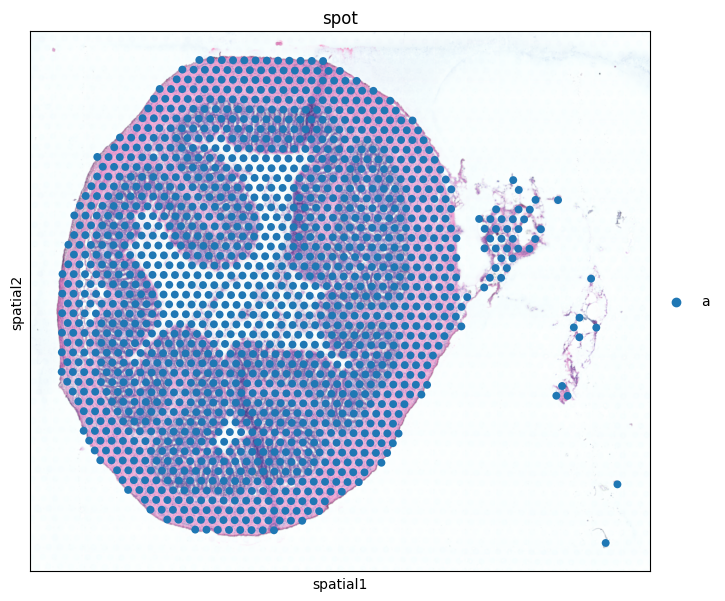

In [26]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, color='spot')